# Insert MODIS-derived land class in SUMMA set up
Inserts mode land class of each HRU into the attributes `.nc` file. The intersection code stores a histogram of land classes in fields `IGBP_{1,...,17}`.

In [1]:
# modules
import os
import numpy as np
import netCDF4 as nc4
import geopandas as gpd
from pathlib import Path
from shutil import copyfile
from datetime import datetime

#### Control file handling

In [2]:
# Easy access to control file folder
controlFolder = Path('../../../0_control_files')

In [3]:
# Store the name of the 'active' file in a variable
controlFile = 'control_active.txt'

In [4]:
# Function to extract a given setting from the control file
def read_from_control( file, setting ):
    
    # Open 'control_active.txt' and ...
    with open(file) as contents:
        for line in contents:
            
            # ... find the line with the requested setting
            if setting in line and not line.startswith('#'):
                break
    
    # Extract the setting's value
    substring = line.split('|',1)[1]      # Remove the setting's name (split into 2 based on '|', keep only 2nd part)
    substring = substring.split('#',1)[0] # Remove comments, does nothing if no '#' is found
    substring = substring.strip()         # Remove leading and trailing whitespace, tabs, newlines
       
    # Return this value    
    return substring

In [5]:
# Function to specify a default path
def make_default_path(suffix):
    
    # Get the root path
    rootPath = Path( read_from_control(controlFolder/controlFile,'root_path') )
    
    # Get the domain folder
    domainName = read_from_control(controlFolder/controlFile,'domain_name')
    domainFolder = 'domain_' + domainName
    
    # Specify the forcing path
    defaultPath = rootPath / domainFolder / suffix
    
    return defaultPath

#### Find shapefile location and name

In [6]:
# Path to and name of shapefile with intersection between catchment and soil classes
intersect_path = read_from_control(controlFolder/controlFile,'intersect_land_path')
intersect_name = read_from_control(controlFolder/controlFile,'intersect_land_name')

In [7]:
# Specify default path if needed
if intersect_path == 'default':
    intersect_path = make_default_path('shapefiles/catchment_intersection/with_modis') # outputs a Path()
else:
    intersect_path = Path(intersect_path) # make sure a user-specified path is a Path()

In [8]:
# Variable names used in shapefile
intersect_hruId_var = read_from_control(controlFolder/controlFile,'catchment_shp_hruid')

#### Find where the attributes file is

In [9]:
# Attribute path & name
attribute_path = read_from_control(controlFolder/controlFile,'settings_summa_path')
attribute_name = read_from_control(controlFolder/controlFile,'settings_summa_attributes')

In [10]:
# Specify default path if needed
if attribute_path == 'default':
    attribute_path = make_default_path('settings/SUMMA') # outputs a Path()
else:
    attribute_path = Path(attribute_path) # make sure a user-specified path is a Path()

#### Open the files and fill the placeholder values in the attributes file

In [11]:
# Open files
shp = gpd.read_file(intersect_path/intersect_name)

In [12]:
# Open the netcdf file for reading+writing
with nc4.Dataset(attribute_path/attribute_name, "r+") as att:
    
    # Keep track of number of water (class 17) occurrences
    is_water = 0
    
    # Loop over the HRUs in the attributes
    for idx in range(0,len(att['hruId'])):
        
        # Find the HRU ID (attributes file) at this index
        attribute_hru = att['hruId'][idx]
    
        # Find the row in the shapefile that contains info for this HRU
        shp_mask = (shp[intersect_hruId_var].astype(int) == attribute_hru)
        
        # Extract the histogram values
        tmp_hist = []
        for j in range (1,18):
            if 'IGBP_' + str(j) in shp.columns:
                tmp_hist.append(shp['IGBP_' + str(j)][shp_mask].values[0])
            else:
                tmp_hist.append(0)
        
        # Find the index with the most occurences
        # Note: this assumes index == class, but at index 0 we find class 1. 
        # Hence we need to increase this value with +1 
        tmp_lc = np.argmax(np.asarray(tmp_hist)) + 1
        
        # Check the assumption that index == soilclass
        if shp['IGBP_' + str(tmp_lc)][shp_mask].values != tmp_hist[tmp_lc - 1]:
            print('Index and mode land class do not match at hru_id ' + \
                  str(shp[intersect_hruId_var][shp_mask].values[0]))
            tmp_lc = -999
        
        # Handle the case where we have water (IGBP = 17)
        if tmp_lc == 17:
            if any(val > 0 for val in tmp_hist[0:-1]): # HRU is mostly water but other land classes are present
                tmp_lc = np.argmax(np.asarray(tmp_hist[0:-1])) + 1 # select 2nd-most common class
                print('HRU {} is predominantly water but some land is detected. Entering land class {} instead of open water.'.format(attribute_hru,tmp_lc))
            else:
                is_water += 1 # HRU is exclusively water
        
        # Replace the value
        print('Replacing land class {} with {} at HRU {}'.format(att['vegTypeIndex'][idx],tmp_lc,attribute_hru))
        att['vegTypeIndex'][idx] = tmp_lc
        
    # Print water counts
    print('{} HRUs were identified as containing only open water. Note that SUMMA skips hydrologic calculations for such HRUs.'.format(is_water))

Replacing land class 10 with 10 at HRU 1
Replacing land class 10 with 10 at HRU 2
Replacing land class 10 with 10 at HRU 3
Replacing land class 10 with 10 at HRU 4
Replacing land class 10 with 10 at HRU 5
Replacing land class 10 with 10 at HRU 6
Replacing land class 1 with 1 at HRU 7
Replacing land class 10 with 10 at HRU 8
Replacing land class 10 with 10 at HRU 9
Replacing land class 1 with 1 at HRU 10
Replacing land class 10 with 10 at HRU 11
Replacing land class 16 with 16 at HRU 12
Replacing land class 10 with 10 at HRU 13
Replacing land class 10 with 10 at HRU 14
Replacing land class 10 with 10 at HRU 15
Replacing land class 10 with 10 at HRU 16
Replacing land class 10 with 10 at HRU 17
Replacing land class 10 with 10 at HRU 18
Replacing land class 10 with 10 at HRU 19
Replacing land class 10 with 10 at HRU 20
Replacing land class 10 with 10 at HRU 21
Replacing land class 10 with 10 at HRU 22
Replacing land class 10 with 10 at HRU 23
Replacing land class 10 with 10 at HRU 24
Repla

## Check
Plot the identified land classes.

In [13]:
import xarray as xr
import matplotlib as mpl
import matplotlib.pyplot as plt

In [16]:
# Open the files 
shp = gpd.read_file(intersect_path/intersect_name)
att = xr.open_dataset(attribute_path/attribute_name)

In [17]:
# Set HRU IDs as index in the shape
shp = shp.set_index(intersect_hruId_var)

In [18]:
# Sort the shape to match the order of the attributes
shp = shp.loc[att['hruId'].values]

In [19]:
# temporarily store the soiltype in the shape for plotting
shp['vegTypeIndex'] = att['vegTypeIndex'][:]

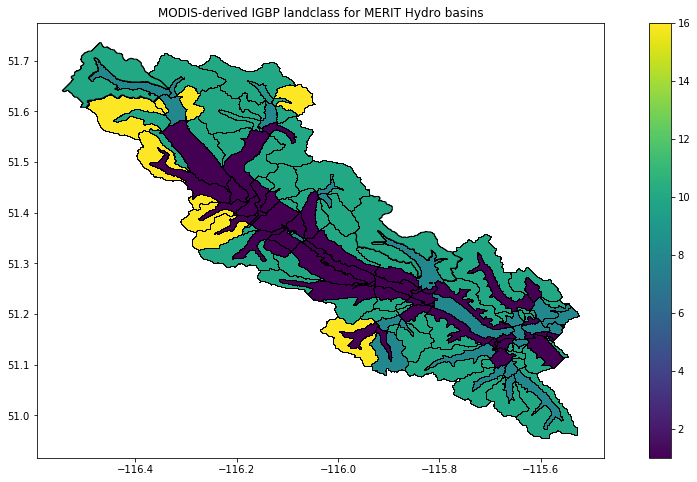

In [20]:
# Make a plot to see what we did
shp.plot(column='vegTypeIndex',figsize=(16,8), legend=True,edgecolor='k')
ax = plt.gca()
ax.set_title('MODIS-derived IGBP landclass');

In [ ]:
# Close the netCDF file
att.close()

#### Code provenance
Generates a basic log file in the domain folder and copies the control file and itself there.

In [21]:
# Set the log path and file name
logPath = attribute_path
log_suffix = '_add_veg_to_attributes.txt'

In [22]:
# Create a log folder
logFolder = '_workflow_log'
Path( logPath / logFolder ).mkdir(parents=True, exist_ok=True)

In [23]:
# Copy this script
thisFile = '2b_insert_landclass_from_hist_into_attributes.ipynb'
copyfile(thisFile, logPath / logFolder / thisFile);

In [24]:
# Get current date and time
now = datetime.now()

In [25]:
# Create a log file 
logFile = now.strftime('%Y%m%d') + log_suffix
with open( logPath / logFolder / logFile, 'w') as file:
    
    lines = ['Log generated by ' + thisFile + ' on ' + now.strftime('%Y/%m/%d %H:%M:%S') + '\n',
             'Added land classes to attributes .nc file.']
    for txt in lines:
        file.write(txt) 